In [1]:
# This program is used to test two versions of our geometrical methods for estimating the uncertainty in AL
import numpy as np
#from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
#import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
#from imblearn.metrics import geometric_mean_score
#from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
#import os
#import sys
from utilsG import DivideSpace2, search_for_labeled_points, divide_space, load_data
from utilsG import SearchforLabeledpoints2, select_instances, draw_divisions
from sklearn.decomposition import PCA

In [2]:
Data=load_data(0)  
Method=2  # we have two geometrical-based models, 1- only entropies of unlabeled data, 2- Counting the no. of labeled points

plot_flag=1
#X, y = Data.data[:, :2], Data.target
X, y = Data.data, Data.target
pca = PCA(n_components=4)
# Fit the PCA model to your data matrix X
pca.fit(X)
# Transform the data matrix X to its lower-dimensional representation
X_reduced = pca.transform(X)
X=X_reduced
if plot_flag==1:
    X=X[:,:2]
X, y = shuffle(X, y, random_state=42)
# Consider only two classes (0 and 1)
X = X[y < 2]
y = y[y < 2]

In [3]:
dim = X.shape[1]  # Number of features (dimensions)
Lb = np.min(X, axis=0)  # Lower boundaries
Ub = np.max(X, axis=0)  # Upper boundaries
# Split the data into labeled and pool sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

In [4]:
np.random.seed(42)
labeled_percentage = 0.04
if labeled_percentage*len(X_train)<1:
    print("The number of initial labeled points is zero")
    exit()
num_labeled_samples = int(labeled_percentage * len(X_train))
permuted_indices = np.random.permutation(len(X_train))

# Select the labeled samples
labeled_indices = permuted_indices[:num_labeled_samples]
X_labeled = X_train[labeled_indices]
y_labeled = y_train[labeled_indices]

# Select the pool samples
pool_indices = permuted_indices[num_labeled_samples:]
X_pool = X_train[pool_indices]
y_pool = y_train[pool_indices]

In [5]:
# Divide the space
NDivisions=2
Quad=DivideSpace2(NDivisions, dim, Lb, Ub)
FoundIn, SumPts_Pool=SearchforLabeledpoints2(dim, Quad, Lb, X_pool)

IIIDDDx = SumPts_Pool == 0
Quad = [q for q, flag in zip(Quad, IIIDDDx) if not flag]
IIIDDDx = None
SumPts = None
FoundIn, SumPts_DL=SearchforLabeledpoints2(dim, Quad, Lb, X_labeled)
Nc=10

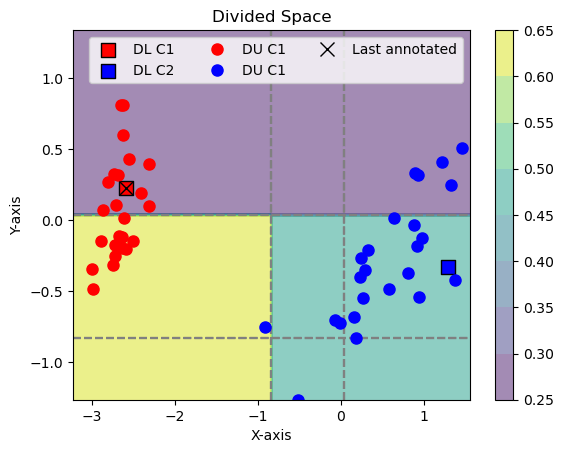

Iteration 1


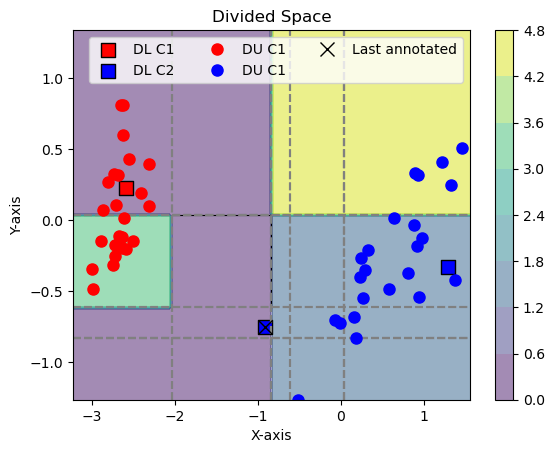

Iteration 2


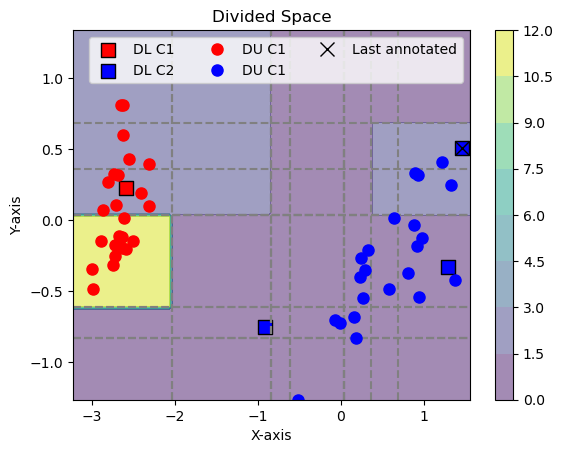

Iteration 3


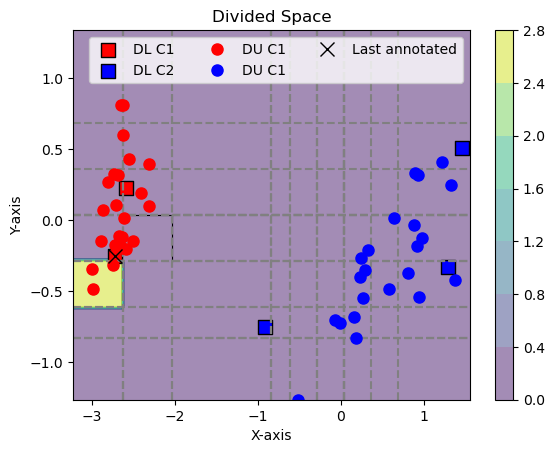

Iteration 4


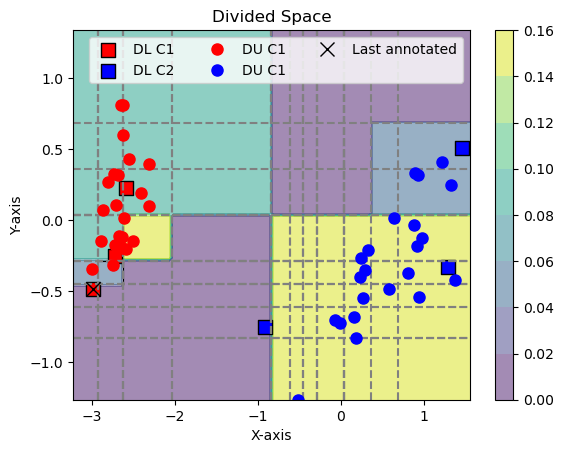

Iteration 5
[0.88, 0.94, 0.94, 1.0, 1.0]


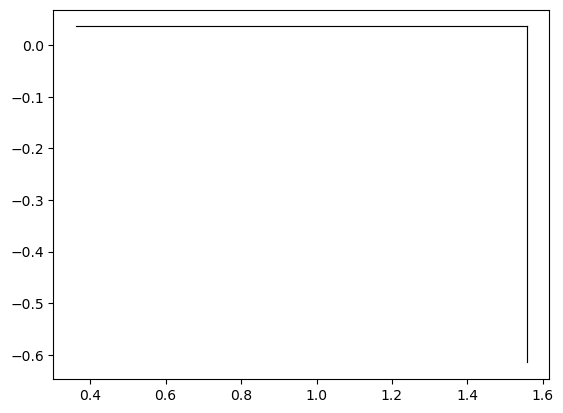

In [6]:
FinalModel=[]
Acc=[]
for iter in range(0,5):
    NewAnnotatedPoint,NewAnnotatedPoint_idx,NewModel, quad_uncertainties=select_instances(FinalModel, X_labeled, y_labeled, X_pool, Lb, Ub, Nc, Quad, Method)           
    if plot_flag==1:
        draw_divisions(Quad, dim, X_labeled, y_labeled, X_pool, y_pool, quad_uncertainties)

    if len(NewModel)>0:
        FinalModel=FinalModel+NewModel
    X_labeled = np.r_[X_labeled, NewAnnotatedPoint.reshape(1,-1)]
    y_labeled= np.r_[y_labeled, y_pool[NewAnnotatedPoint_idx]]
    X_pool = np.delete(X_pool, NewAnnotatedPoint_idx, axis=0)
    y_pool = np.delete(y_pool, NewAnnotatedPoint_idx, axis=0)

    # This code should be run after each annotation
    FoundIn,XX =search_for_labeled_points(dim, Quad, Lb, Ub, X_labeled)
    NewLb = [Quad[i]['Lb'] for i in FoundIn]
    NewUb = [Quad[i]['Ub'] for i in FoundIn]
    FoundIn_int = int(FoundIn[0])
    NewQuad,XX=divide_space(NDivisions,dim, NewLb, NewUb, PlotFlag=1)
    TempTempQuad=Quad
    del Quad[FoundIn_int]
    for ii in range(len(NewQuad)):
        Quad.append(NewQuad[ii])
    _, SumPts = SearchforLabeledpoints2(dim, Quad, Lb,  np.r_[X_labeled, X_pool])
    #if sum(SumPts) != np.r_[X_labeled, X_pool].shape[0]:
    #    print('Problem in Dimensions')

    IIIDDDx = SumPts == 0
    Quad = [quad for quad, i in zip(Quad, IIIDDDx) if not i]
    # test
    clf = RandomForestClassifier()
    clf.fit(X_labeled, y_labeled)
    y_pred = clf.predict(X_test)
    Acc.append(accuracy_score(y_test, y_pred))
    print("Iteration " + str(iter+1))

print(Acc)